In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-00-98416c45f92c'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

In [4]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

import pandas as pd
df_customer_stats = bpd.read_gbq(f'{project_id}.{dataset_name}.{table_name}')
df_customer_stats.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,46814,935,1,12.0
1,8956,888,1,31.5
2,7763,850,2,70.169998
3,62570,1005,1,55.0
4,20181,1066,1,9.56
5,42866,1000,1,128.0
6,44876,899,1,89.989998
7,88957,846,2,28.940001
8,3996,1016,1,265.0
9,9940,813,3,25.876666


In [5]:
# prompt: bqdf = client.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
# df.head(10)

df = client.query(f"SELECT * FROM `{project_id}.{dataset_name}.{table_name}`").to_dataframe()
df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,51080,768,1,39.990002
1,48685,768,1,23.969999
2,82490,768,1,61.790001
3,1335,768,1,68.000000
4,47601,768,1,59.990002
5,49291,768,1,8.950000
6,12158,768,1,65.000000
7,45522,768,1,13.900000
8,25489,768,1,20.000000
9,84077,768,1,58.840000


In [6]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2025-02-02 21:19:05.561566+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_id,days_since_last_order,count_orders,average_spend
0,46814,935,1,12.0
1,8956,888,1,31.5
2,7763,850,2,70.169998
3,62570,1005,1,55.0
4,20181,1066,1,9.56
5,42866,1000,1,128.0
6,44876,899,1,89.989998
7,88957,846,2,28.940001
8,3996,1016,1,265.0
9,9940,813,3,25.876666


In [7]:
# prompt: #prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.
# df_train, df_test = train_test_split(bq_df, test_siz

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)

kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [8]:
# prompt: # prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.
# predictions_df = kmeans.predict(df_test)
# predictions_df.head(10)

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.502886469936...",62570,1005,1,55.0
10,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.975565658564...",62138,1104,1,15.99
23,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.809171980251...",86508,1005,1,28.0
24,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.454758143394...",69005,834,1,134.0
27,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.449974263383...",77262,1015,1,47.990002
30,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.780868234976...",3304,842,1,135.0
31,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.830723873815...",21263,1000,1,24.99
50,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.111220229685...",90269,889,2,47.974998
56,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.156224784307...",92107,772,1,25.0
57,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.674490032565...",75358,990,1,144.399994


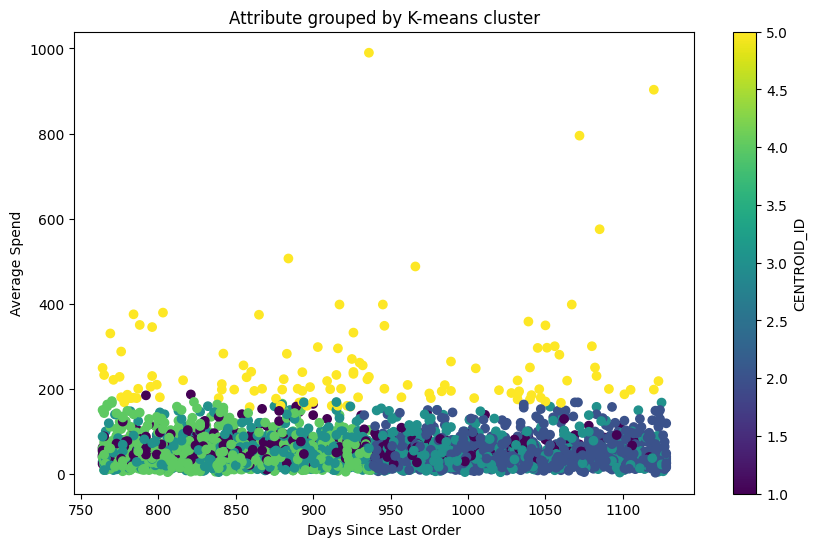

In [9]:
# prompt: #prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."
# import matplotlib.pyplot as plt
# # Create the scatter plot
# plt.figure(figsize=(10, 6))  # Adjust figure s

import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='CENTROID_ID')
plt.show()

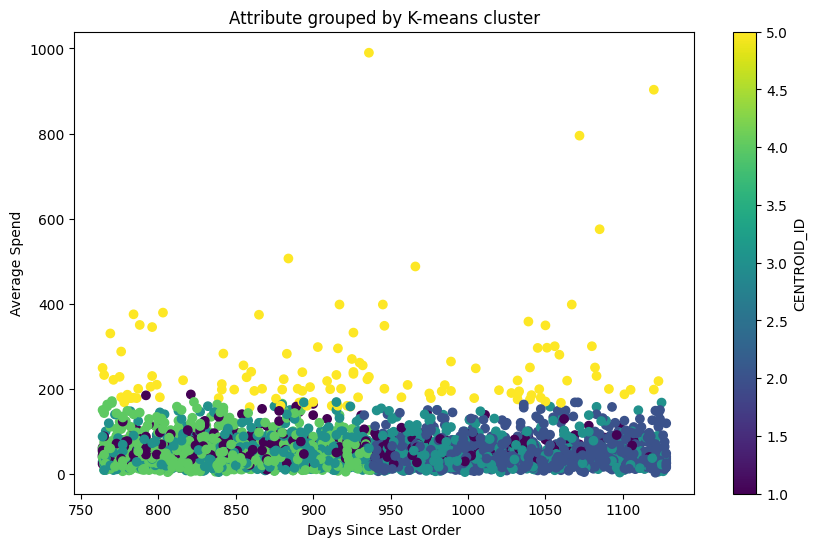

In [10]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='CENTROID_ID')
plt.show()

In [11]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,57.13,3.72,896.48
1,cluster 2,50.88,1.31,1035.24
2,cluster 3,50.18,1.28,931.69
3,cluster 4,49.96,1.33,838.38
4,cluster 5,264.59,1.23,927.18


In [12]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $57.13, count of orders per person 3.72, days since last order 896.48
cluster 2, average spend $50.88, count of orders per person 1.31, days since last order 1035.24
cluster 3, average spend $50.18, count of orders per person 1.28, days since last order 931.69
cluster 4, average spend $49.96, count of orders per person 1.33, days since last order 838.38
cluster 5, average spend $264.59, count of orders per person 1.23, days since last order 927.18


In [13]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [15]:
model = GenerativeModel("gemini-1.0-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 800,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

## Creative Brand Personas and Marketing Actions for Each Cluster:

**Cluster 1:**

* **Title:** The Loyal Lapsed Customer
* **Persona:** This customer has a history of making multiple purchases but hasn't engaged with the brand in nearly two and a half years. They likely had positive experiences in the past and may be open to re-engagement with the right incentive.
* **Next Marketing Step:** 
    1. **Targeted Email Campaign:** Send a personalized email acknowledging their past purchases and highlighting new products, promotions, or loyalty program benefits. 
    2. **Exclusive Offer:** Provide a special discount or offer tailored to their previous purchase history to entice them back.
    3. **Win-back Campaign:** Utilize retargeting ads on social media or search engines to remind them of the brand and encourage a return purchase.

**Cluster 2:**

* **Title:** The One-Time Wonder
* **Persona:** This customer made a single purchase over three years ago and hasn't returned. They may ha